### Week 5 - More on working with climate model output
#### Doing an area-weighted spatial average of global data

The first 4 cells are repeat from last week

In [1]:
import numpy as np
import matplotlib.pyplot as py
import math
import xarray

In [2]:
#read in temperature data
filename = 'cmip6_tas.nc'
nc_file = xarray.open_dataset(filename)
tasdata = nc_file['tas'].data - 273.15 #convert to celsius
time = nc_file['time'].data
lat = nc_file['lat'].data
lon = nc_file['lon'].data

In [3]:
time
#the time dimension has all the months from Jan 1850 to Dec 2014

array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ...,
       '2014-10-16T12:00:00.000000000', '2014-11-16T00:00:00.000000000',
       '2014-12-16T12:00:00.000000000'], dtype='datetime64[ns]')

In [4]:
#make an array, date, for all the years 1850-2014
nyears = int(len(time)/12)
date = np.zeros(nyears)
for i in range(nyears):
    date[i] = 1850 + i

In [5]:
date

array([1850., 1851., 1852., 1853., 1854., 1855., 1856., 1857., 1858.,
       1859., 1860., 1861., 1862., 1863., 1864., 1865., 1866., 1867.,
       1868., 1869., 1870., 1871., 1872., 1873., 1874., 1875., 1876.,
       1877., 1878., 1879., 1880., 1881., 1882., 1883., 1884., 1885.,
       1886., 1887., 1888., 1889., 1890., 1891., 1892., 1893., 1894.,
       1895., 1896., 1897., 1898., 1899., 1900., 1901., 1902., 1903.,
       1904., 1905., 1906., 1907., 1908., 1909., 1910., 1911., 1912.,
       1913., 1914., 1915., 1916., 1917., 1918., 1919., 1920., 1921.,
       1922., 1923., 1924., 1925., 1926., 1927., 1928., 1929., 1930.,
       1931., 1932., 1933., 1934., 1935., 1936., 1937., 1938., 1939.,
       1940., 1941., 1942., 1943., 1944., 1945., 1946., 1947., 1948.,
       1949., 1950., 1951., 1952., 1953., 1954., 1955., 1956., 1957.,
       1958., 1959., 1960., 1961., 1962., 1963., 1964., 1965., 1966.,
       1967., 1968., 1969., 1970., 1971., 1972., 1973., 1974., 1975.,
       1976., 1977.,

Calculate the average for every year and then weight based on the area of the respective gridcell. The cells at the poles are much smaller and so we want them to have a smaller weight, compared to the tropics, when calculating the global average. 

In [6]:
tasyearmean = np.zeros((nyears, len(lat), len(lon))) #for every year, a lat x lon grid
globaltas = np.zeros(nyears) #for every year, have one global mean temperature

for t in range(nyears):
    tasyearmean[t,:,:] = np.mean(tasdata[t*12 : t*12+12, :, :], axis=0)
    globaltas[t] = np.average(tasyearmean[t, :, :]) #unweighted
    
tasfinal = tasyearmean[-1,:,:]
tasinitial = tasyearmean[0,:,:]
tasdiff = tasfinal - tasinitial

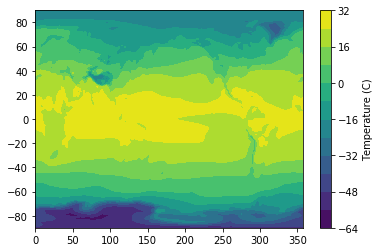

In [7]:
fig = py.figure(1)
ax1 = fig.add_subplot(111)
contour_plot = ax1.contourf(lon, lat, tasinitial, 10)
cbar = py.colorbar(contour_plot)
cbar.set_label('Temperature (C)')

Plot the change in T from the first year to the last year

In [8]:
tasfinal = tasyearmean[-1,:,:]
tasinitial = tasyearmean[0,:,:]
tasdiff = tasfinal - tasinitial #map of change in temperature 

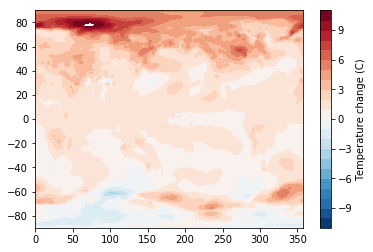

In [9]:
fig = py.figure(2)
ax1 = fig.add_subplot(111)
contour_plot = ax1.contourf(lon, lat, tasdiff, np.arange(-11,12), cmap='RdBu_r')
cbar = py.colorbar(contour_plot)
cbar.set_label('Temperature change (C)')

So far, we have not weighted each cell by its area when calculating the global average. There are two ways to get the weights: First, using geometry of a sphere and doing a calculation for each cell. Second, using the NC file from CMIP6 which gives us the weight of each cell in a separate file.

#### First: do the geometric calculations
Each cell will have a weighted area based on its latitude. Cells closer to the poles should be smaller.

In [10]:
arealat = np.zeros(len(lat)) 
Re = 6.371e6 #radius of earth
dlat = (lat[1] - lat[0])/2
print('lat diff =', dlat)

lat diff = 0.6338043212890625


In [11]:
for i in range(len(lat)):
    htop = Re*(1 - math.sin(math.radians(lat[i] + dlat)))
    hbot = Re*(1 - math.sin(math.radians(lat[i] - dlat)))
    areatop = 2 * math.pi * Re * htop
    areabot = 2 * math.pi * Re * hbot
    areadiff = areabot - areatop
    arealat[i] = areadiff/len(lon)

In [12]:
arealat

array([0.00000000e+00, 8.66789053e+08, 1.73314865e+09, 2.59866517e+09,
       3.46290457e+09, 4.32545428e+09, 5.18588689e+09, 6.04377612e+09,
       6.89871240e+09, 7.75026700e+09, 8.59803337e+09, 9.44159145e+09,
       1.02805233e+10, 1.11144284e+10, 1.19428887e+10, 1.27655085e+10,
       1.35818802e+10, 1.43915994e+10, 1.51942796e+10, 1.59895230e+10,
       1.67769355e+10, 1.75561391e+10, 1.83267522e+10, 1.90883930e+10,
       1.98406910e+10, 2.05832782e+10, 2.13157909e+10, 2.20378728e+10,
       2.27491662e+10, 2.34493251e+10, 2.41380068e+10, 2.48148763e+10,
       2.54795982e+10, 2.61318493e+10, 2.67713101e+10, 2.73976679e+10,
       2.80106178e+10, 2.86098562e+10, 2.91950916e+10, 2.97660376e+10,
       3.03224147e+10, 3.08639522e+10, 3.13903818e+10, 3.19014475e+10,
       3.23968992e+10, 3.28764958e+10, 3.33399990e+10, 3.37871854e+10,
       3.42178341e+10, 3.46317357e+10, 3.50286862e+10, 3.54084927e+10,
       3.57709680e+10, 3.61159353e+10, 3.64432264e+10, 3.67526799e+10,
      

Check: What would the surface area of the Earth be if we summed up all the cells' area?

In [13]:
areaofearth = 0
for i in range(len(lat)):
    for j in range(len(lon)):
        areaofearth = areaofearth + arealat[i]
print(areaofearth)

510034474863602.0


#### Second: compare with weights from the CMIP6 NC file for the area weights

In [14]:
#get area info
filename = 'area_historical.nc'
nc_file = xarray.open_dataset(filename)
areacella = nc_file['areacella'].data
nc_file.close()

print(np.sum(areacella)) #total surface area of the earth, 5.1 x 10^14 m2

510103740000000.0


#### Get the data at Irvine and make a timeseries

In [15]:
irvlat = 33.642
irvlon = -117.845

#check the units for lat and lon
print(nc_file['lat'].units)
print(nc_file['lon'].units)

degrees_north
degrees_east


Latitude goes from -90 to 90 and Longitude goes from 0 to 360. We need to change our irvlon from degrees west to degrees east

In [16]:
if irvlon < 0:
    irvlon = irvlon + 360
print(irvlat, irvlon)

33.642 242.155


Find where in the array is closest to our coordinates

In [25]:
i_irv = np.abs(lat-irvlat).argmin()
j_irv = np.abs(lon-irvlon).argmin()

print('index', i, j)
print(lat[i], lon[j])

index 142 97
90.0 242.5


Slice the temperature data to get all time but just at Irvine

In [18]:
irvinetemp = tasyearmean[:, i, j]

In [19]:
print(irvinetemp)

[12.64730358 13.28980255 12.99163532 12.86723614 12.90242004 13.12049866
 11.96374989 12.94230175 13.08946228 13.81430531 13.62560558 13.18972015
 13.45226574 12.94089508 13.39479065 13.6166811  13.53238392 13.80602741
 13.62599182 12.41217518 12.76410389 13.36533833 13.71126842 12.23472595
 13.4382906  12.5757246  13.0665617  13.31151867 13.73142242 13.73644733
 12.81497478 13.07192993 12.78622723 13.7241745  12.27441406 12.58465099
 12.67870808 12.55276966 13.09175873 13.36061859 13.47134399 13.2208252
 13.37557983 12.75403118 13.53039074 12.79531384 13.27024555 12.7634964
 13.01006794 13.33927631 12.77612019 13.28398609 13.2338562  12.10312366
 13.19494629 11.82152081 13.56450653 13.35055256 12.76074505 12.48672771
 12.35968494 12.91493702 12.75849628 12.51644897 13.24208546 12.12034893
 14.00715637 13.2780714  12.03249836 13.24842548 13.57125854 12.85796833
 12.70863628 13.30848217 11.95149517 12.99810028 13.25824738 13.61178589
 12.79832172 13.10560131 12.62080097 13.04926014 11.9

Text(0.5, 0, 'Time')

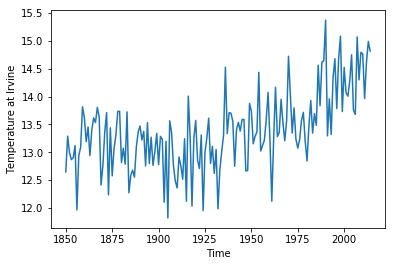

In [20]:
fig = py.figure(3)
py.plot(date, irvinetemp)
py.ylabel('Temperature at Irvine')
py.xlabel('Time')

#### Hovmoller temperature plot: Temperature change against latitude through time

Slow way to calculate mean across longitudes

In [39]:
hovdata = np.zeros((nyears, len(lat)))
for t in range(nyears):
    for i in range(len(lat)):
        hovdata[t, i] = np.average(tasyearmean[t,i,:])

Fast way of doing the same thing

In [55]:
hovdata = np.mean(tasyearmean, axis=2)

In [57]:
hovdata.shape #(years, lat)

(165, 143)

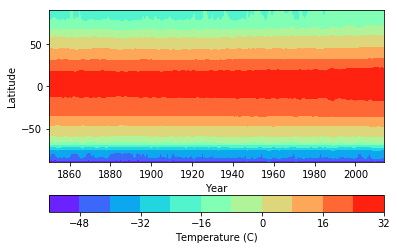

In [58]:
#plot
fig = py.figure(4)
ax1 = fig.add_subplot(111)
contour_plot = ax1.contourf(date, lat, hovdata.T, 10, cmap='rainbow')
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Year')
cbar = py.colorbar(contour_plot, orientation='horizontal')
cbar.set_label('Temperature (C)')

Now look at just the temperature anomaly against the first 10 years (subtract out the average from the first 10 years)

In [64]:
hovstart = np.average(hovdata[0:10, :], axis=0) #average across first 10 years
print(hovstart)

[-52.23283577 -50.94634163 -48.49079781 -44.42124776 -41.18134146
 -40.37373564 -39.77268855 -39.60911889 -39.77106658 -38.95039362
 -36.86331559 -34.64632454 -31.97341918 -29.23075476 -25.70510245
 -22.35265655 -18.83567162 -15.06575628 -11.2448274   -8.54044343
  -6.99287926  -5.18199861  -3.57793212  -2.21180556  -1.01052212
   0.12529505   1.18450179   2.13486092   2.9105366    3.68177388
   4.40472284   5.12464158   5.82087407   6.5525335    7.31949501
   8.11321104   8.94796687   9.85532192  10.7790359   11.89465174
  12.92668105  13.77484186  14.56981529  15.41121034  16.11273538
  16.6499812   17.22327535  17.89377931  18.48466406  19.01128426
  19.47748986  20.02254385  20.56767209  21.00304333  21.45518305
  21.8373192   22.21908696  22.51606544  22.91111281  23.13391447
  23.4319987   23.85686749  24.18672822  24.38610265  24.54015075
  24.70502964  24.78215216  24.82229361  24.69881867  24.66080766
  24.48334645  24.44791762  24.59296949  24.85885475  25.01238726
  25.07138

In [65]:
hovanomaly = hovdata - hovstart

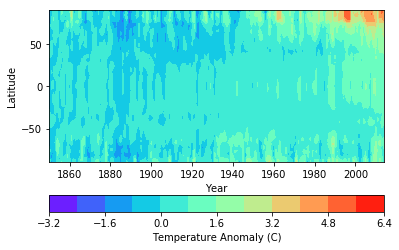

In [67]:
#plot
fig = py.figure(5)
ax1 = fig.add_subplot(111)
contour_plot = ax1.contourf(date, lat, hovanomaly.T, 10, cmap='rainbow')
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Year')
cbar = py.colorbar(contour_plot, orientation='horizontal')
cbar.set_label('Temperature Anomaly (C)')